## SLI Training Script 
## By Luis A. Urso
## 16-MAR-2023 - version 2
##
## Release Notes:
## - Hyperparameters adjustments: Changed the RNN architecture, 1st Drop-Out to 10% and 2nd Drop-Out to 5%
## - Prediction Test adjustments and improvements
## - Confusion Matrix visual improvements
## - Full code review

In [79]:
import csv
import os
import sys

import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import plot_model

from random import randint

import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_SEED = 86

# Setup Global Variables

 Define the files path

In [80]:
dataset = 'model/training_data.csv'
model_save_path = 'model/training_classifierf.hdf5'
tflite_save_path = 'model/training_classifier.tflite'

def get_script_path():
    return os.path.dirname(os.path.realpath(sys.argv[0]))


app_path=get_script_path()

Set number of classes to be trained

In [81]:
# Define the number of classes to be trained 

with open('model/labels.csv',encoding='utf-8-sig') as f_labels:
	labels_class = csv.reader(f_labels)
	labels_class = [
		row[0] for row in labels_class
	]

# Get the Classes Text

classes_text=[]
for rlb in labels_class:
	if rlb!="None":
		classes_text.append(rlb)


NUM_CLASSES = len(labels_class)

print("Classes to be trained:",NUM_CLASSES)

Classes to be trained: 37


# Dataset Preparation

Dataset loading

In [82]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [83]:
X_dataset.shape

(16381, 42)

In [84]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [85]:
y_dataset.shape

(16381,)

Split Data Sets into Train and Test

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model Architecture & Building

FNN Model Arquitecture

In [87]:
## Possible Architecture, may need to test this over the used one below, to see if better results are acquired.

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input((21 * 2, )),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(42, activation='relu'),
#     tf.keras.layers.Dropout(0.05),
#     tf.keras.layers.Dense(21, activation='relu'),
#     tf.keras.layers.Dropout(0.02),
#     tf.keras.layers.Dense(10, activation='relu'),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

## Architecture in Use - this is the approved one.

model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])



In [88]:
## Print the RNN Architeture Summary 

model.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 37)                407       
                                                                 
Total params: 1,477
Trainable params: 1,477
Non-trainable params: 0
_________________________________________________________________


Model Pre-building Verification 

In [89]:
# Model checkpoint callback / Model Saving
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

# Callback for early stopping / definitions
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

Model Compilation

In [90]:
# Model compilation

model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training

In [91]:
model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
87/96 [==========================>...] - ETA: 0s - loss: 3.5674 - accuracy: 0.0635
Epoch 1: saving model to model\training_classifierf.hdf5
96/96 [==============================] - 1s 3ms/step - loss: 3.5605 - accuracy: 0.0644 - val_loss: 3.4546 - val_accuracy: 0.0981
Epoch 2/500
66/96 [===================>..........] - ETA: 0s - loss: 3.3514 - accuracy: 0.1136
Epoch 2: saving model to model\training_classifierf.hdf5
96/96 [==============================] - 0s 2ms/step - loss: 3.3012 - accuracy: 0.1271 - val_loss: 3.1056 - val_accuracy: 0.1948
Epoch 3/500
49/96 [==============>...............] - ETA: 0s - loss: 3.0226 - accuracy: 0.1814
Epoch 3: saving model to model\training_classifierf.hdf5
96/96 [==============================] - 0s 2ms/step - loss: 2.8956 - accuracy: 0.2088 - val_loss: 2.5809 - val_accuracy: 0.2883
Epoch 4/500
85/96 [=========================>....] - ETA: 0s - loss: 2.4436 - accuracy: 0.3136
Epoch 4: saving model to model\training_classifierf.hdf5
96/96

# Training Evaluation

In [92]:
# Model evaluation

val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

32/32 [==============================] - 0s 749us/step - loss: 0.1880 - accuracy: 0.9502


In [93]:
# Loading the saved model

model = tf.keras.models.load_model(model_save_path)

In [107]:
# Predictions Test 

test_size = 20
test_list = np.random.randint(0,len(X_test),test_size)  
counter=0

# Table Header Definition

print("#Run\tTest Label\tTest Class\tPredicted Label\t\tPredicted Class\t\tEvaluation")
print("--------------------------------------------------------------------------------------------------")

# Table Details Definition with Prediction Funciton 

for pred_index in range(0,len(test_list)):
    
    predict_result = model.predict(np.array([X_test[pred_index]]),verbose=0)
    predicted_label=np.argmax(np.squeeze(predict_result)) # get the index of the max element of the array
    
    counter+=1

    if classes_text[y_test[pred_index]] != classes_text[predicted_label]:
        eval = "DIFF"
    else:
        eval = "EQUAL"
        
    print(counter,"\t",np.array([y_test[pred_index]])+1,"\t\t",classes_text[y_test[pred_index]],"\t\t",
          predicted_label+1,"\t\t\t",classes_text[predicted_label],"\t\t\t",eval)
    

#Run	Test Label	Test Class	Predicted Label		Predicted Class		Evaluation
--------------------------------------------------------------------------------------------------
1 	 [4] 		 D 		 4 			 D 			 EQUAL
2 	 [2] 		 B 		 2 			 B 			 EQUAL
3 	 [10] 		 J 		 10 			 J 			 EQUAL
4 	 [16] 		 P 		 16 			 P 			 EQUAL
5 	 [2] 		 B 		 2 			 B 			 EQUAL
6 	 [27] 		 1 		 27 			 1 			 EQUAL
7 	 [5] 		 E 		 5 			 E 			 EQUAL
8 	 [32] 		 6 		 32 			 6 			 EQUAL
9 	 [9] 		 I 		 27 			 1 			 DIFF
10 	 [18] 		 R 		 18 			 R 			 EQUAL
11 	 [11] 		 K 		 11 			 K 			 EQUAL
12 	 [8] 		 H 		 8 			 H 			 EQUAL
13 	 [2] 		 B 		 2 			 B 			 EQUAL
14 	 [11] 		 K 		 11 			 K 			 EQUAL
15 	 [29] 		 3 		 29 			 3 			 EQUAL
16 	 [27] 		 1 		 27 			 1 			 EQUAL
17 	 [32] 		 6 		 32 			 6 			 EQUAL
18 	 [18] 		 R 		 18 			 R 			 EQUAL
19 	 [9] 		 I 		 9 			 I 			 EQUAL
20 	 [25] 		 Y 		 25 			 Y 			 EQUAL


# Confusion Matrix

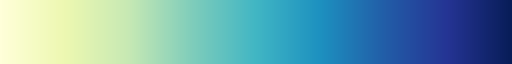

In [95]:
sns.color_palette("YlGnBu", as_cmap=True)

128/128 [==============================] - 0s 676us/step


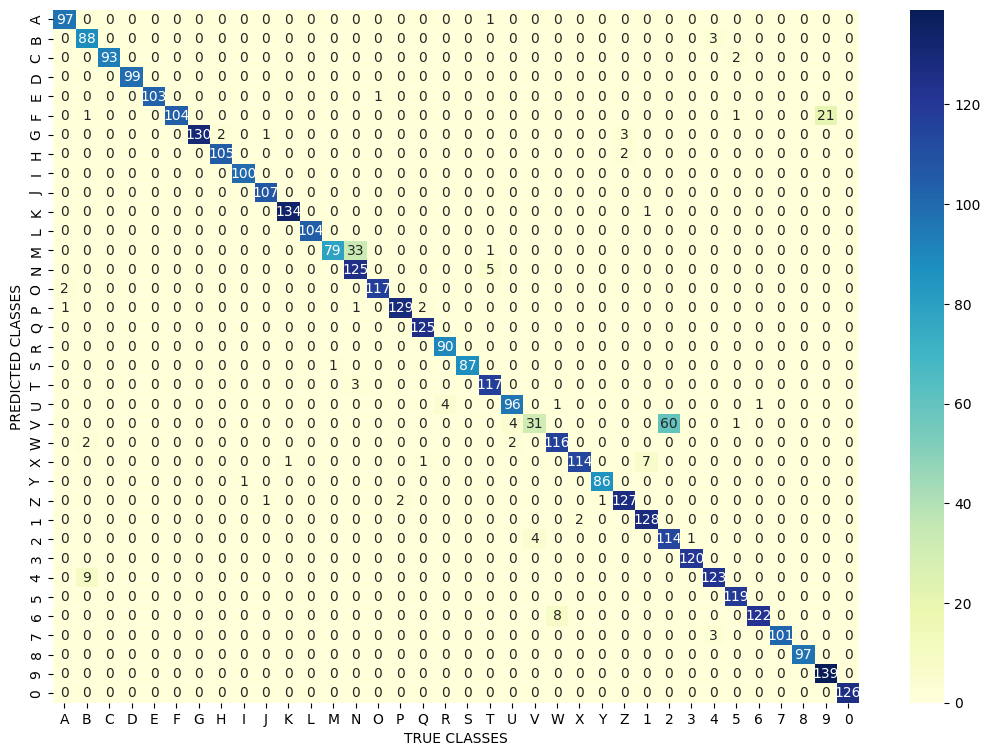

Classification Report
              precision    recall  f1-score   support

           1       0.97      0.99      0.98        98
           2       0.88      0.97      0.92        91
           3       1.00      0.98      0.99        95
           4       1.00      1.00      1.00        99
           5       1.00      0.99      1.00       104
           6       1.00      0.82      0.90       127
           7       1.00      0.96      0.98       136
           8       0.98      0.98      0.98       107
           9       0.99      1.00      1.00       100
          10       0.98      1.00      0.99       107
          11       0.99      0.99      0.99       135
          12       1.00      1.00      1.00       104
          13       0.99      0.70      0.82       113
          14       0.77      0.96      0.86       130
          15       0.99      0.98      0.99       119
          16       0.98      0.97      0.98       133
          17       0.98      1.00      0.99       125
     

In [96]:
# Set the fonts for confusion matrix
# Color Palette: YlGnBu

font_title = {'family': 'arial',
              'color':  'darkred',
              'weight': 'normal',
              'size': 16}

font_lables = {'family': 'arial',
               'color':  'black',
               'weight': 'normal',
               'size': 11}

def show_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=classes_text, columns=classes_text)
 
    fig, ax = plt.subplots(figsize=(13, 9))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False, cmap="YlGnBu")
    ax.set_ylim(len(set(y_true)), 0)

    # plt.title("Confuxion Matrix",fontdict=font)
    plt.xlabel("TRUE CLASSES")
    plt.ylabel("PREDICTED CLASSES")
    
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

show_confusion_matrix(y_test, y_pred)

# Convert Model for Tensorflow-Lite

In [97]:
# Save as a model dedicated to inference

model.save(model_save_path, include_optimizer=False)

In [98]:
# Transform model to TensorFlow Lite and Quantized 

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\laurs\AppData\Local\Temp\tmplmvhnguz\assets


INFO:tensorflow:Assets written to: C:\Users\laurs\AppData\Local\Temp\tmplmvhnguz\assets


8048

# Inference Test

In [99]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [100]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [101]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [102]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


Check if all labels were considered in the TFLITE file.

In [103]:
print(" ")
print("Recorded Labels:",len(np.squeeze(tflite_results)),"of",NUM_CLASSES,"Original Trained Labels:")
print(" ")
print("                      *** END OF TRAINIG ***")
print(" ")
print("                      Thanks :) - Luis Urso ")

 
Recorded Labels: 37 of 37 Original Trained Labels:
 
                      *** END OF TRAINIG ***
 
                      Thanks :) - Luis Urso 
